In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime

# Set visualization style
plt.style.use('ggplot')  # Using a standard style that should be available
sns.set()  # Default seaborn style
plt.rcParams['figure.figsize'] = (12, 6)

# Load the NYC Housing Dataset
file_path = 'data\Final_NYC_Housing_Dataset.csv'
df = pd.read_csv(file_path)

# Display basic information
print(f"Dataset Shape: {df.shape}")
print("\nFirst 5 rows:")
df.head()

Dataset Shape: (83, 14)

First 5 rows:


,DATE,ZHVI,YOY_CHANGE,SALES_VOLUME,INVENTORY,DOM,MORTGAGE,POPULATION,UNEMPLOYMENT_RATE,MEDIAN_INCOME,CPI,MARKET_HEAT_INDEX,GOOGLE_TREND,CONSUMER_SENTIMENT
0,2018-03,652524.0089,7.756677,14047,73707,68,4.4440,NaN,4.3,NaN,249.577,55,67,101.4
1,2018-04,656864.5454,7.471338,14780,80345,65,4.4675,NaN,4.2,NaN,250.227,56,55,98.8
2,2018-05,661945.9429,7.625250,16869,85864,63,4.5860,NaN,4.1,NaN,250.792,55,62,98.0
3,2018-06,665867.5000,7.632281,19562,90067,64,4.5700,NaN,4.0,NaN,251.018,52,63,98.2
4,2018-07,669849.7909,7.815212,19467,91881,66,4.5275,NaN,3.9,NaN,251.214,53,68,97.9


In [2]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found.")

# Convert DATE to datetime format if it's not already
if df['DATE'].dtype != 'datetime64[ns]':
    df['DATE'] = pd.to_datetime(df['DATE'])

# Summary statistics
print("\nSummary Statistics:")
df.describe().T

# Check the time range of the dataset
print(f"\nData time range: {df['DATE'].min()} to {df['DATE'].max()}")
print(f"Total period: {(df['DATE'].max() - df['DATE'].min()).days // 30} months")

Missing values in each column:
POPULATION           77
UNEMPLOYMENT_RATE     1
MEDIAN_INCOME        78
dtype: int64

Summary Statistics:

Data time range: 2018-03-01 00:00:00 to 2025-01-01 00:00:00
Total period: 83 months


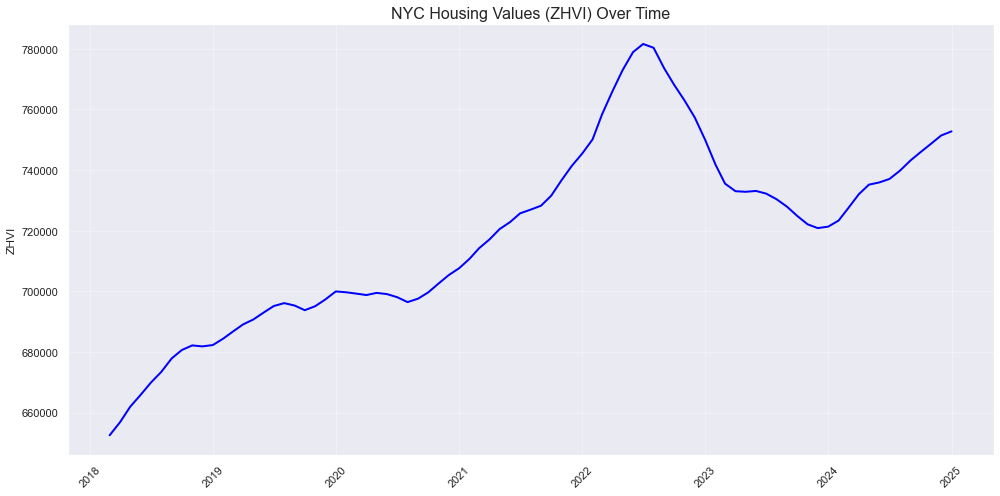

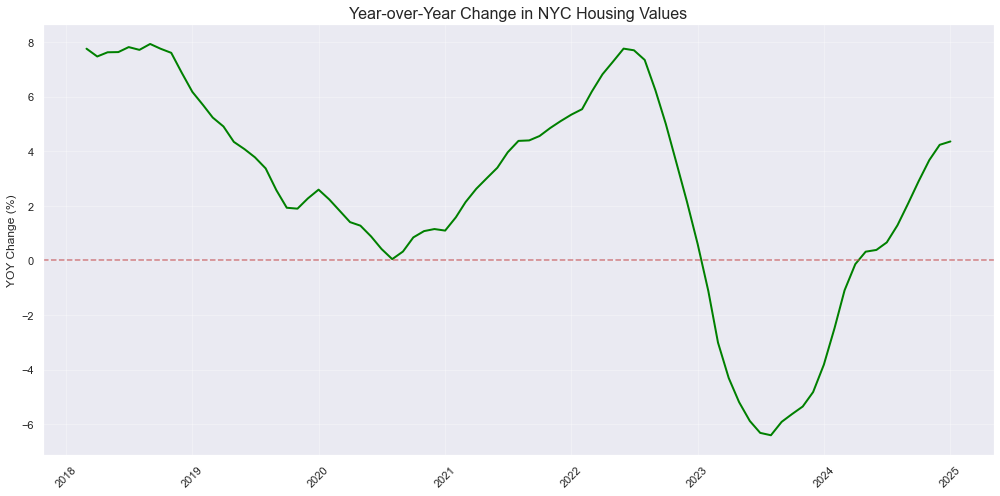

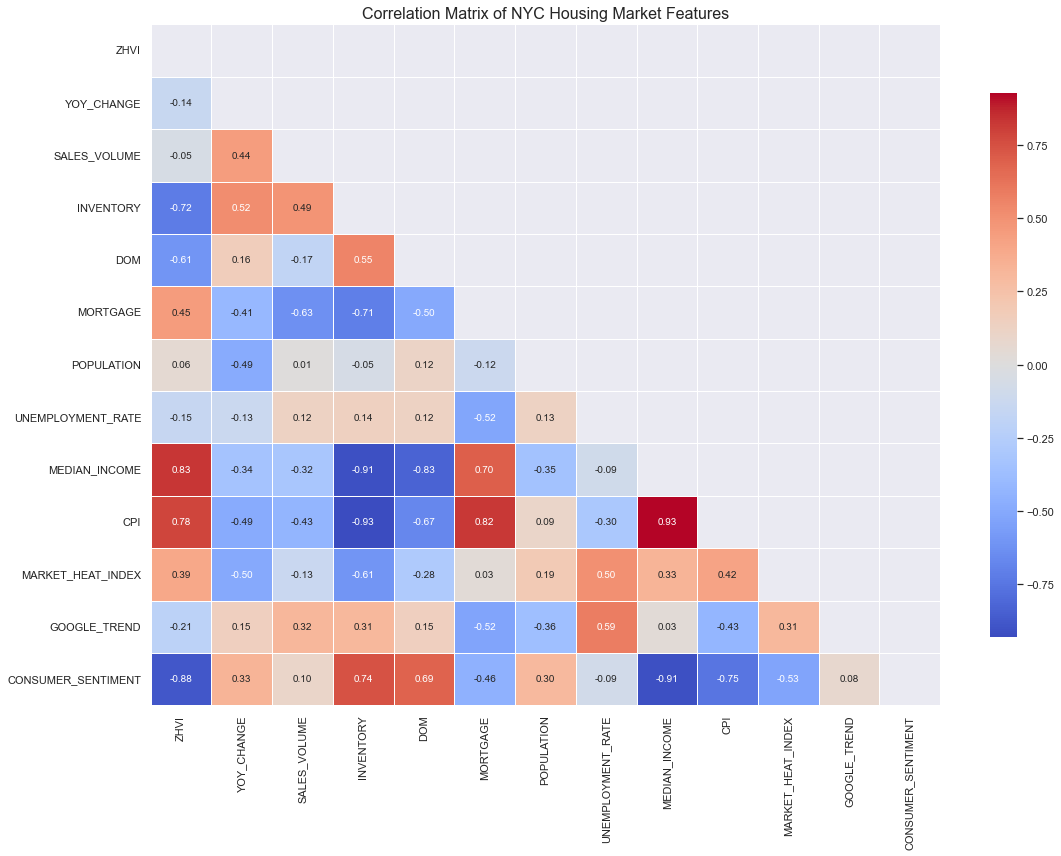

In [3]:
# Set the DATE as index for time series analysis
df_ts = df.copy()
df_ts.set_index('DATE', inplace=True)

# Plot ZHVI (housing values) over time
plt.figure(figsize=(14, 7))
plt.plot(df_ts.index, df_ts['ZHVI'], color='blue', linewidth=2)
plt.title('NYC Housing Values (ZHVI) Over Time', fontsize=16)
plt.ylabel('ZHVI', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot YOY_CHANGE to see annual growth rate
plt.figure(figsize=(14, 7))
plt.plot(df_ts.index, df_ts['YOY_CHANGE'], color='green', linewidth=2)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
plt.title('Year-over-Year Change in NYC Housing Values', fontsize=16)
plt.ylabel('YOY Change (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation heatmap of key variables
plt.figure(figsize=(16, 12))
correlation_matrix = df_ts.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of NYC Housing Market Features', fontsize=16)
plt.tight_layout()
plt.show()

In [4]:
# Create a copy of the dataframe for preprocessing
df_processed = df.copy()

# Set DATE as index if not already
if 'DATE' in df_processed.columns:
    df_processed.set_index('DATE', inplace=True)

# Handle missing values (if any)
if df_processed.isnull().sum().sum() > 0:
    print("Handling missing values...")
    df_processed = df_processed.interpolate(method='time')
    
    # Check if all missing values are handled
    missing_after = df_processed.isnull().sum().sum()
    print(f"Missing values after interpolation: {missing_after}")

# Group features by category
housing_features = ['ZHVI', 'YOY_CHANGE', 'SALES_VOLUME', 'INVENTORY', 'DOM']
economic_features = ['MORTGAGE', 'POPULATION', 'UNEMPLOYMENT_RATE', 'MEDIAN_INCOME', 'CPI']
sentiment_features = ['MARKET_HEAT_INDEX', 'GOOGLE_TREND', 'CONSUMER_SENTIMENT']

# Scale numerical features
scaler = StandardScaler()
numerical_cols = df_processed.select_dtypes(include=['float64', 'int64']).columns
df_scaled = df_processed.copy()
df_scaled[numerical_cols] = scaler.fit_transform(df_processed[numerical_cols])

print("Preprocessing completed.")
print(f"Shape of processed dataframe: {df_processed.shape}")
print(f"Shape of scaled dataframe: {df_scaled.shape}")

# Display head of the scaled dataframe
df_scaled.head()

Handling missing values...
Missing values after interpolation: 20
Preprocessing completed.
Shape of processed dataframe: (83, 13)
Shape of scaled dataframe: (83, 13)


,ZHVI,YOY_CHANGE,SALES_VOLUME,INVENTORY,DOM,MORTGAGE,POPULATION,UNEMPLOYMENT_RATE,MEDIAN_INCOME,CPI,MARKET_HEAT_INDEX,GOOGLE_TREND,CONSUMER_SENTIMENT
DATE,,,,,,,,,,,,,
2018-03-01,-2.172370,1.339970,-0.427440,0.533105,-0.164517,-0.233815,NaN,-0.418495,NaN,-1.255217,-1.152892,0.852069,1.612918
2018-04-01,-2.029986,1.267216,-0.234909,0.891110,-0.357747,-0.218817,NaN,-0.456087,NaN,-1.227879,-1.082116,-0.381449,1.433075
2018-05-01,-1.863299,1.306460,0.313793,1.188763,-0.486567,-0.143189,NaN,-0.493679,NaN,-1.204115,-1.152892,0.338103,1.377739
2018-06-01,-1.734659,1.308252,1.021142,1.415442,-0.422157,-0.153401,NaN,-0.531271,NaN,-1.194610,-1.365222,0.440896,1.391573
2018-07-01,-1.604027,1.354895,0.996189,1.513276,-0.293337,-0.180524,NaN,-0.568863,NaN,-1.186366,-1.294446,0.954862,1.370822


In [5]:
def engineer_features(df, key_features):
    """
    Create engineered features for time series analysis
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe with time index
    key_features : list
        List of column names to create features from
    
    Returns:
    --------
    pandas.DataFrame
        Dataframe with engineered features
    """
    df_eng = df.copy()
    
    # Create lagged features
    print("Creating lagged features...")
    for feature in key_features:
        for lag in [1, 3, 6, 12]:
            if lag < len(df):
                df_eng[f'{feature}_lag_{lag}'] = df_eng[feature].shift(lag)
    
    # Moving averages
    print("Creating moving averages...")
    for feature in key_features:
        for window in [3, 6, 12]:
            if window < len(df):
                df_eng[f'{feature}_ma_{window}'] = df_eng[feature].rolling(window=window).mean()
    
    # Rate of change
    print("Creating rate of change features...")
    for feature in key_features:
        df_eng[f'{feature}_roc_3'] = df_eng[feature].pct_change(periods=3) * 100
        df_eng[f'{feature}_roc_6'] = df_eng[feature].pct_change(periods=6) * 100
    
    # Create ratio features
    print("Creating ratio features...")
    if all(col in df_eng.columns for col in ['ZHVI', 'MEDIAN_INCOME']):
        df_eng['price_to_income'] = df_eng['ZHVI'] / df_eng['MEDIAN_INCOME']
    
    if all(col in df_eng.columns for col in ['INVENTORY', 'SALES_VOLUME']):
        df_eng['inventory_to_sales'] = df_eng['INVENTORY'] / df_eng['SALES_VOLUME'].replace(0, np.nan)
    
    if all(col in df_eng.columns for col in ['MEDIAN_INCOME', 'ZHVI', 'MORTGAGE']):
        df_eng['affordability'] = df_eng['MEDIAN_INCOME'] / (df_eng['ZHVI'] * df_eng['MORTGAGE'] / 100)
    
    # Momentum indicators
    print("Creating momentum indicators...")
    if 'ZHVI' in df_eng.columns:
        # Relative Strength Index (RSI) - simplified version
        delta = df_eng['ZHVI'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss.replace(0, np.nan)
        df_eng['RSI'] = 100 - (100 / (1 + rs))
    
    # Drop rows with NaN values created by lagging/rolling
    initial_rows = len(df_eng)
    df_eng = df_eng.dropna()
    print(f"Dropped {initial_rows - len(df_eng)} rows with NaN values.")
    
    return df_eng

# Select key features for engineering
key_features_for_eng = ['ZHVI', 'YOY_CHANGE', 'SALES_VOLUME', 'INVENTORY', 
                         'DOM', 'MORTGAGE', 'UNEMPLOYMENT_RATE', 'MARKET_HEAT_INDEX']

# Apply feature engineering
df_engineered = engineer_features(df_processed, key_features_for_eng)

# Display the number of features before and after engineering
print(f"\nNumber of features before engineering: {df_processed.shape[1]}")
print(f"Number of features after engineering: {df_engineered.shape[1]}")

# Display the first few rows of the engineered dataset
df_engineered.head()

Creating lagged features...
Creating moving averages...
Creating rate of change features...
Creating ratio features...
Creating momentum indicators...
Dropped 23 rows with NaN values.

Number of features before engineering: 13
Number of features after engineering: 89


,ZHVI,YOY_CHANGE,SALES_VOLUME,INVENTORY,DOM,MORTGAGE,POPULATION,UNEMPLOYMENT_RATE,MEDIAN_INCOME,CPI,...,MORTGAGE_roc_3,MORTGAGE_roc_6,UNEMPLOYMENT_RATE_roc_3,UNEMPLOYMENT_RATE_roc_6,MARKET_HEAT_INDEX_roc_3,MARKET_HEAT_INDEX_roc_6,price_to_income,inventory_to_sales,affordability,RSI
DATE,,,,,,,,,,,,,,,,,,,,,
2019-04-01,689100.2629,4.907514,14125,84211,92,4.1425,19621.442233,3.8,71063.424658,255.233,...,-7.202061,-14.233954,-5.000000,-5.000000,-1.754386,19.148936,9.696975,5.961841,2.489437,99.125153
2019-05-01,690693.8707,4.342942,16558,91255,86,4.0720,19674.212644,3.7,70801.232877,255.296,...,-6.819222,-16.317304,-5.128205,-7.500000,-13.559322,8.510638,9.755393,5.511233,2.517372,99.161065
2019-06-01,693005.2849,4.075553,17575,95966,81,3.8025,19728.742068,3.7,70530.301370,255.213,...,-10.844080,-18.005391,-5.128205,-7.500000,-13.793103,-3.846154,9.825639,5.460370,2.676517,99.114797
2019-07-01,695156.8146,3.778015,18920,97260,81,3.7650,19781.512479,3.8,70268.109589,255.802,...,-9.112855,-15.658602,0.000000,-5.000000,-5.357143,-7.017544,9.892920,5.140592,2.684791,99.038206
2019-08-01,696112.2362,3.371708,19169,95383,85,3.6160,19836.041904,3.8,69997.178082,256.036,...,-11.198428,-17.254005,2.702703,-2.564103,9.803922,-5.084746,9.944861,4.975899,2.780820,98.945871


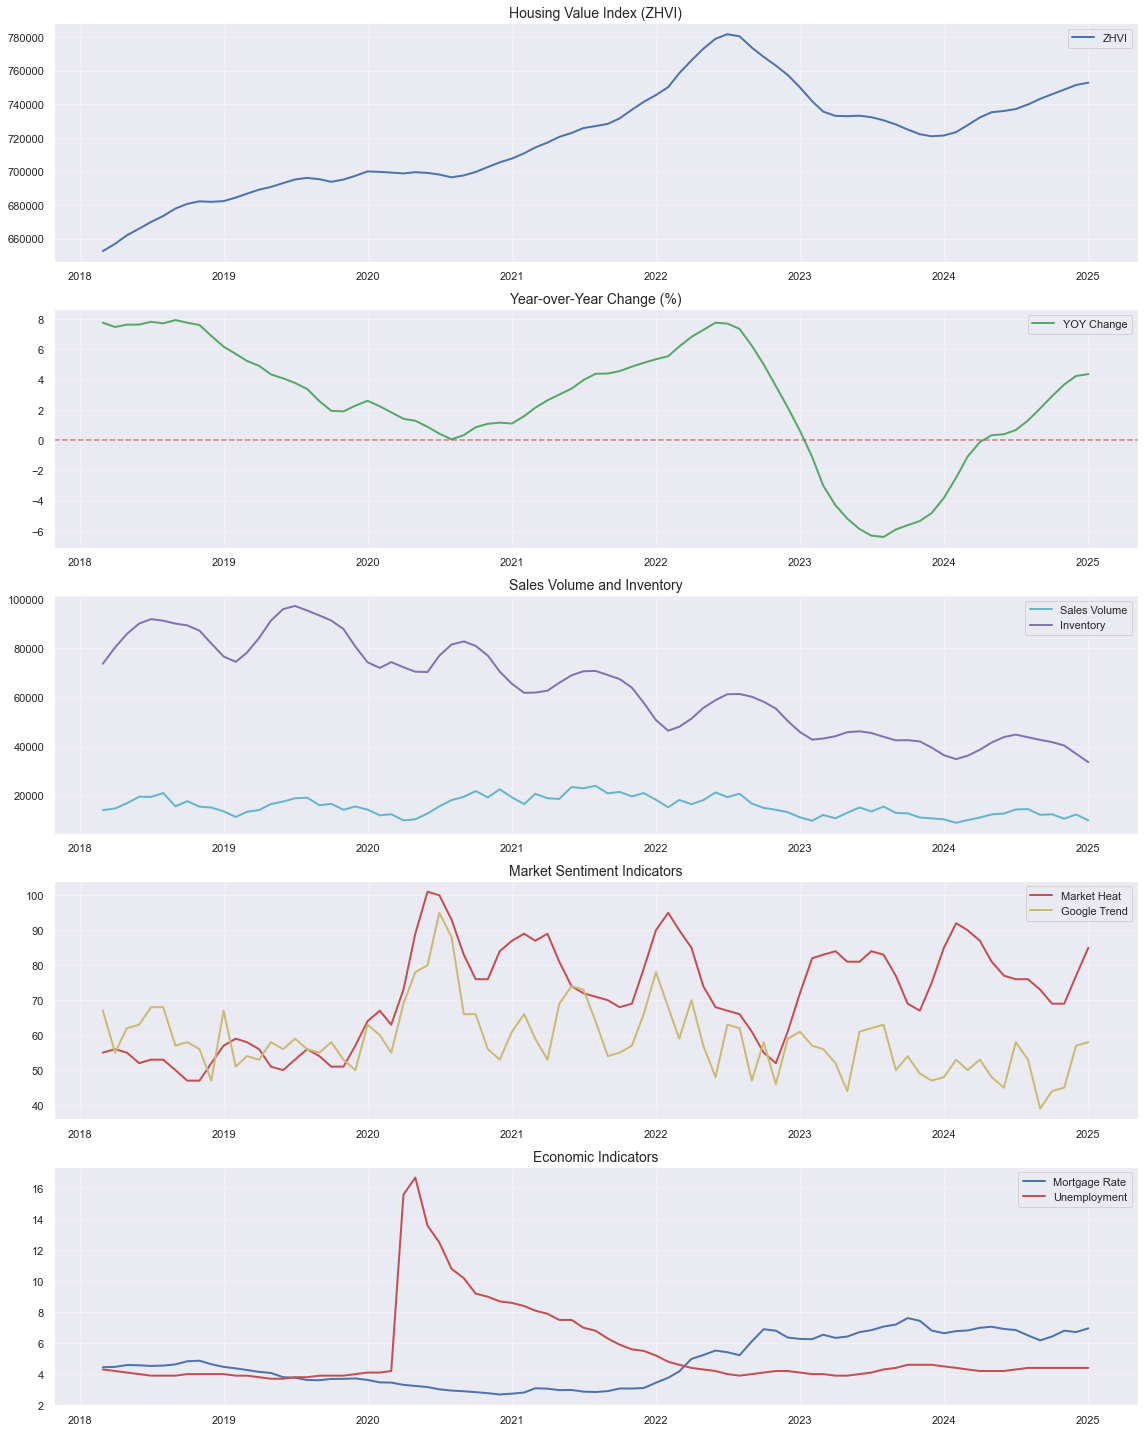

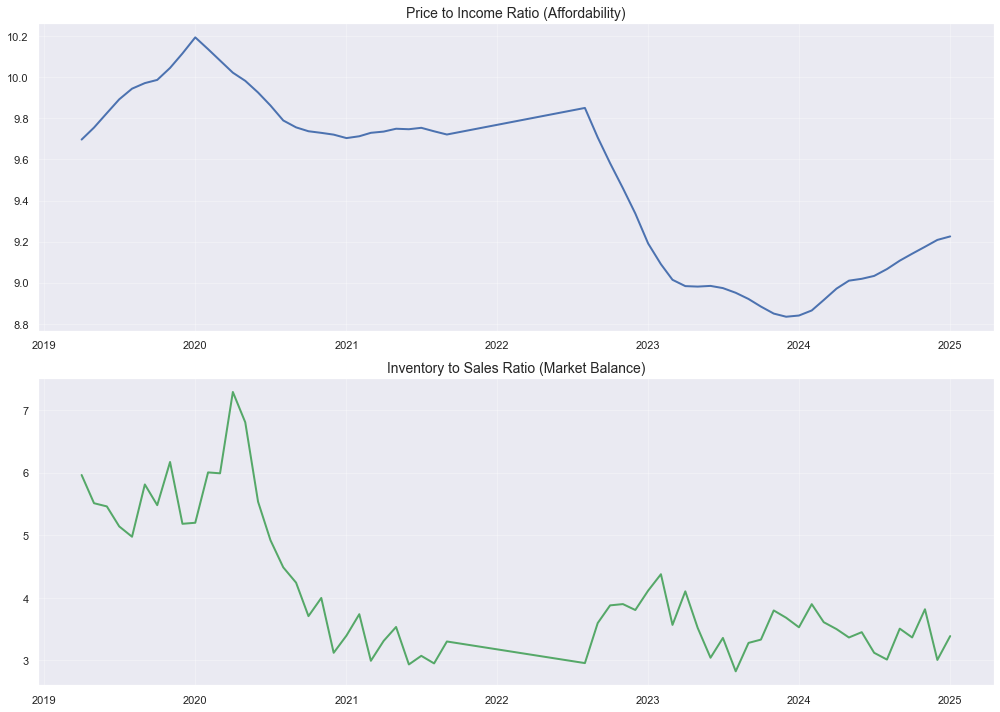

In [6]:
# Plot key features that might help identify different regimes
plt.figure(figsize=(16, 20))

# Housing value and YOY change
plt.subplot(5, 1, 1)
plt.plot(df_processed.index, df_processed['ZHVI'], 'b-', linewidth=2, label='ZHVI')
plt.title('Housing Value Index (ZHVI)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(df_processed.index, df_processed['YOY_CHANGE'], 'g-', linewidth=2, label='YOY Change')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.7)
plt.title('Year-over-Year Change (%)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Sales and inventory dynamics
plt.subplot(5, 1, 3)
plt.plot(df_processed.index, df_processed['SALES_VOLUME'], 'c-', linewidth=2, label='Sales Volume')
plt.plot(df_processed.index, df_processed['INVENTORY'], 'm-', linewidth=2, label='Inventory')
plt.title('Sales Volume and Inventory', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Market sentiment indicators
plt.subplot(5, 1, 4)
plt.plot(df_processed.index, df_processed['MARKET_HEAT_INDEX'], 'r-', linewidth=2, label='Market Heat')
plt.plot(df_processed.index, df_processed['GOOGLE_TREND'], 'y-', linewidth=2, label='Google Trend')
plt.title('Market Sentiment Indicators', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Economic indicators
plt.subplot(5, 1, 5)
plt.plot(df_processed.index, df_processed['MORTGAGE'], 'b-', linewidth=2, label='Mortgage Rate')
plt.plot(df_processed.index, df_processed['UNEMPLOYMENT_RATE'], 'r-', linewidth=2, label='Unemployment')
plt.title('Economic Indicators', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Check if we have engineered ratio features to plot
if 'price_to_income' in df_engineered.columns and 'inventory_to_sales' in df_engineered.columns:
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(df_engineered.index, df_engineered['price_to_income'], 'b-', linewidth=2)
    plt.title('Price to Income Ratio (Affordability)', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.plot(df_engineered.index, df_engineered['inventory_to_sales'], 'g-', linewidth=2)
    plt.title('Inventory to Sales Ratio (Market Balance)', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()